In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
sys.path.append("/scratch/izar/kapps/DEX-Cyclic-Arbitrage/")
from config.get import cfg
# from tensorflow import keras
# from tensorflow.keras import layers
import autoencoders

2022-01-05 13:44:32.698393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-05 13:44:32.698441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loading the data

In [7]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(2698, 3, 600, 2),X_test=(675, 3, 600, 2)


# Loading the model

In [3]:
model_name , autoencoder = autoencoders.linear_simple()
autoencoder.summary()

2022-01-05 12:39:58.100549: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-05 12:39:58.100628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (izar): /proc/driver/nvidia/version does not exist
2022-01-05 12:39:58.102236: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 600, 2)]       0         
                                                                 
 reshape (Reshape)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 100)               360100    
                                                                 
 dense_1 (Dense)             (None, 3600)              363600    
                                                                 
 reshape_1 (Reshape)         (None, 3, 600, 2)         0         
                                                                 
Total params: 723,700
Trainable params: 723,700
Non-trainable params: 0
_________________________________________________________________


# Training 

In [4]:
hist = autoencoder.fit(X_train, X_train,epochs=100)

Epoch 1/100
85/85 [==============================] - 13s 75ms/step - loss: 0.4552
Epoch 2/100
85/85 [==============================] - 7s 79ms/step - loss: 0.2175
Epoch 3/100
85/85 [==============================] - 7s 79ms/step - loss: 0.1728
Epoch 4/100
85/85 [==============================] - 6s 69ms/step - loss: 0.1495
Epoch 5/100
85/85 [==============================] - 6s 74ms/step - loss: 0.1348
Epoch 6/100
85/85 [==============================] - 6s 74ms/step - loss: 0.1281
Epoch 7/100
85/85 [==============================] - 7s 77ms/step - loss: 0.1208
Epoch 8/100
85/85 [==============================] - 7s 77ms/step - loss: 0.1173
Epoch 9/100
85/85 [==============================] - 6s 71ms/step - loss: 0.1162
Epoch 10/100
85/85 [==============================] - 6s 73ms/step - loss: 0.1138
Epoch 11/100
85/85 [==============================] - 6s 75ms/step - loss: 0.1197
Epoch 12/100
85/85 [==============================] - 6s 72ms/step - loss: 0.1127
Epoch 13/100
85/85 [====

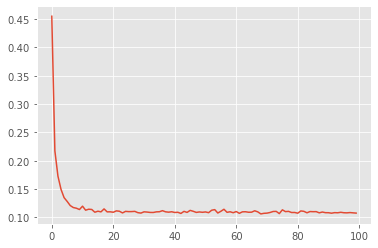

In [5]:
plt.plot(hist.history["loss"])
plt.show()

# Testing

In [12]:
def mean_squared_error(x,y):
    return np.sum((x-y)**2)/x.size

In [6]:
train_pred = autoencoder(X_train).numpy()
test_pred  = autoencoder(X_test).numpy()

print(f"MSE train : {mean_squared_error(train_pred,X_train)} \nMSE test  : {mean_squared_error(test_pred,X_test)}")

MSE train : 0.10556992541704721 
MSE test  : 0.11754054001508757


# Comparison with PCA


In [8]:
N_train = len(X_train)
N_test  = len(X_test)
tX_train = X_train.reshape(N_train,-1)
tX_test = X_test.reshape(N_test,-1)

In [13]:
from sklearn import decomposition
def eval_PCA(n_components=100):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(tX_train)
    pca_train = mean_squared_error(tX_train, pca.inverse_transform(pca.transform(tX_train)))
    pca_test =  mean_squared_error(tX_test, pca.inverse_transform(pca.transform(tX_test))) 
    return pca_train,pca_test

In [19]:
pca_train,pca_test = eval_PCA()
print(f"MSE train : {pca_train} \nMSE test  : {pca_test}")

MSE train : 0.09561804790068397 
MSE test  : 0.10705392637737407


## effect of dimension

In [ ]:
train_errors = []
test_errors  = []
d_max = min(tX_train.shape)
dimensions = np.logspace(np.log10(5), np.log10(d_max), num=50).astype(int)
for d in dimensions:
    pca_train,pca_test = eval_PCA(n_components=d)
    train_errors.append(pca_train)
    test_errors.append(pca_test)
    print(d,end="\r")

In [ ]:
plt.scatter(x=dimensions,y=test_errors,label="test")
plt.scatter(x=dimensions,y=train_errors,label="train")
plt.xlabel("dimension")
plt.ylabel("error")
plt.legend()
plt.title("effect of dimension reduction on reconstruction errors")
plt.show()

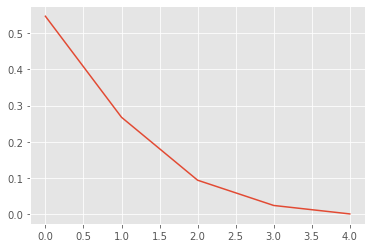

In [30]:
plt.plot(test_errors)